<a href="https://colab.research.google.com/github/JoDeMiro/DeepLearningIntroduction/blob/main/11_Reinforcement_Learning_without_Gradient_Descent_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Olvasmány magának a Cart-pool-v1-nek a máködéséről.

https://gym.openai.com/envs/CartPole-v1/



```
"This environment corresponds to the version of the cart-pole problem described
by Barto, Sutton, and Anderson [Barto83]."


[Barto83] AG Barto, RS Sutton and CW Anderson, "Neuronlike Adaptive Elements
That Can Solve Difficult Learning Control Problem", IEEE Transactions on
Systems, Man, and Cybernetics, 1983.
```


Számos nagyon jó videó készült az OpenAI Gym használatáról:

- https://www.youtube.com/watch?v=JNKvJEzuNsc&ab_channel=RichardBrooker


Vicces demok:

\- https://www.youtube.com/watch?v=5Q14EjnOJZc&ab_channel=Cheng-YuehLiu

\- https://www.youtube.com/watch?v=vHd7vtadwdc&ab_channel=KOREATECHLINK



In [1]:
!pip install pygad

In [2]:
import time
import gym
import numpy as np
import pygad.torchga
import pygad
import torch
import torch.nn as nn
from multiprocessing import Pool



In [3]:
def fitness_func(solution, sol_idx):
    global model, observation_space_size, env

    model_weights_dict = pygad.torchga.model_weights_as_dict(model=model, weights_vector=solution)
    model.load_state_dict(model_weights_dict)

    # play game
    observation = env.reset()
    sum_reward = 0
    done = False
    while (not done) and (sum_reward < 1000):
        # env.render()
        ob_tensor = torch.tensor(observation.copy(), dtype=torch.float)
        q_values = model(ob_tensor)
        action = np.argmax(q_values).numpy()
        observation_next, reward, done, info = env.step(action)
        observation = observation_next
        sum_reward += reward

    return sum_reward



In [4]:
def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))



In [5]:
def fitness_wrapper(solution):
    return fitness_func(solution, 0)



In [6]:
class PooledGA(pygad.GA):

    def cal_pop_fitness(self):
        global pool

        pop_fitness = pool.map(fitness_wrapper, self.population)
        print("pop_fitness = ", pop_fitness)
        pop_fitness = np.array(pop_fitness)
        return pop_fitness




## Render OpenAI Gym Environments from CoLab

It is possible to visualize the game your agent is playing, even on CoLab. This section provides information on how to generate a video in CoLab that shows you an episode of the game your agent is playing. This video process is based on suggestions found <a href="https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t">here</a>.

Begin by installing **pyvirtualdisplay** and python-opengl.

In [7]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

Next, we install needed requirements to display an Atari game.

In [8]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

Sajnos még ezek is kellenek.

In [9]:
%%capture
import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')

!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!python -m atari_py.import_roms rars

Next we define functions used to show the video by adding it to the CoLab notebook.

In [10]:
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

## Teszteljük le, hogy működik-e egyáltalán a Gym

In [11]:
env = wrap_env(gym.make("Atlantis-v0"))

observation = env.reset()

while True:
  
    # env.render()
    env.render(mode='rgb_array')
    
    #your agent goes here
    action = env.action_space.sample() 
         
    observation, reward, done, info = env.step(action) 
   
        
    if done: 
      break;
            
env.close()
show_video()

## Működik, jöhet az igazi kód

Kicsit szétdaraboltam cellákra mert mindegyikhez szeretnék hozzáfűzni valamilyen megjegyzést.

In [12]:
env = gym.make("CartPole-v1")

In [13]:
?env.env    # Segítségével kaphatunk inormációt az aktuális gym env-ről

In [14]:
# helyett a wrappert kell használni Google Colab alatt
env = wrap_env(gym.make("CartPole-v1"))


pop_fitness =  [9.0, 28.0, 9.0, 141.0, 9.0, 11.0, 10.0, 9.0, 10.0, 26.0]
pop_fitness =  [92.0, 30.0, 49.0, 11.0, 10.0, 10.0, 8.0, 28.0, 8.0, 34.0]
Generation = 1
pop_fitness =  [152.0, 18.0, 29.0, 8.0, 8.0, 8.0, 8.0, 16.0, 10.0, 79.0]
Fitness    = 152.0
pop_fitness =  [147.0, 51.0, 61.0, 19.0, 19.0, 10.0, 9.0, 15.0, 16.0, 11.0]
Generation = 2
pop_fitness =  [193.0, 85.0, 51.0, 21.0, 21.0, 10.0, 9.0, 16.0, 17.0, 12.0]
Fitness    = 193.0
pop_fitness =  [167.0, 49.0, 53.0, 23.0, 22.0, 92.0, 9.0, 9.0, 34.0, 23.0]
Generation = 3
pop_fitness =  [161.0, 108.0, 48.0, 21.0, 18.0, 115.0, 8.0, 8.0, 24.0, 24.0]
Fitness    = 161.0
pop_fitness =  [146.0, 115.0, 85.0, 50.0, 30.0, 121.0, 9.0, 9.0, 23.0, 9.0]
Generation = 4
pop_fitness =  [180.0, 108.0, 31.0, 195.0, 20.0, 121.0, 21.0, 9.0, 18.0, 8.0]
Fitness    = 195.0
pop_fitness =  [180.0, 123.0, 84.0, 43.0, 58.0, 80.0, 75.0, 8.0, 30.0, 81.0]
Generation = 5
pop_fitness =  [183.0, 123.0, 101.0, 35.0, 58.0, 95.0, 91.0, 19.0, 51.0, 33.0]
Fitness    = 18

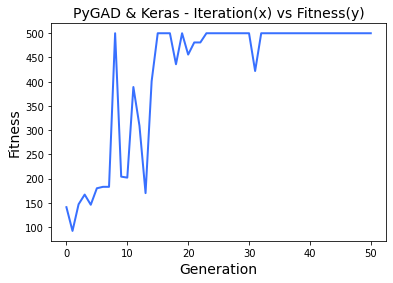

In [15]:

# helyett a wrappert kell használni Google Colab alatt
env = wrap_env(gym.make("CartPole-v1"))

observation_space_size = env.observation_space.shape[0]

action_space_size = env.action_space.n

torch.set_grad_enabled(False)

model = nn.Sequential(
    nn.Linear(observation_space_size, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, action_space_size)
)

torch_ga = pygad.torchga.TorchGA(model=model, num_solutions=10)

# Prepare the PyGAD parameters. Check the documentation for more information:
# https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html#pygad-ga-class
num_generations = 50              # Number of generations.
num_parents_mating = 5            # Number of solutions to be selected as parents in the mating pool.
initial_population = torch_ga.population_weights  # Initial population of network weights
parent_selection_type = "sss"     # Type of parent selection.
crossover_type = "single_point"   # Type of the crossover operator.
mutation_type = "random"          # Type of the mutation operator.
mutation_percent_genes = 10       # Percentage of genes to mutate. This parameter has no action if the parameter mutation_num_genes exists.
keep_parents = -1                 # Number of parents to keep in the next population. -1 means keep all parents and 0 means keep nothing.

start_time = time.time()

# ga_instance = pygad.GA(num_generations=num_generations,
#                        num_parents_mating=num_parents_mating,
#                        initial_population=initial_population,
#                        fitness_func=fitness_func,
#                        parent_selection_type=parent_selection_type,
#                        crossover_type=crossover_type,
#                        mutation_type=mutation_type,
#                        mutation_percent_genes=mutation_percent_genes,
#                        keep_parents=keep_parents,
#                        on_generation=callback_generation)
#
# ga_instance.run()

ga_instance = PooledGA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       parent_selection_type=parent_selection_type,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       keep_parents=keep_parents,
                       on_generation=callback_generation)

with Pool(processes=10) as pool:
    ga_instance.run()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
    print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

    print("--- %s seconds ---" % (time.time() - start_time))

    model_weights_dict = pygad.torchga.model_weights_as_dict(model=model, weights_vector=solution)
    model.load_state_dict(model_weights_dict)

    # play game
    observation = env.reset()
    sum_reward = 0
    done = False
    while not done:
        # env.render()
        # env.render() paraméter nélkül panaszkodni szokott Google Colab alatt ezért lecseréltem erre
        env.render(mode='rgb_array')

        ob_tensor = torch.tensor(observation.copy(), dtype=torch.float)
        q_values = model(ob_tensor)
        action = np.argmax(q_values).numpy()
        observation_next, reward, done, info = env.step(action)
        observation = observation_next
        sum_reward += reward

    print("Sum reward: " + str(sum_reward))

# After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
ga_instance.plot_fitness(title="PyGAD & Keras - Iteration(x) vs Fitness(y)", linewidth=2)

# Az env még nem lett lezárva, le kell zárni.
env.close()


In [16]:
env.close()

In [17]:
show_video()